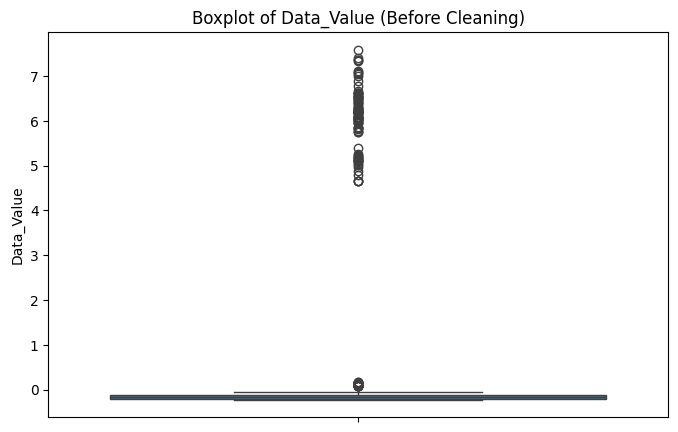

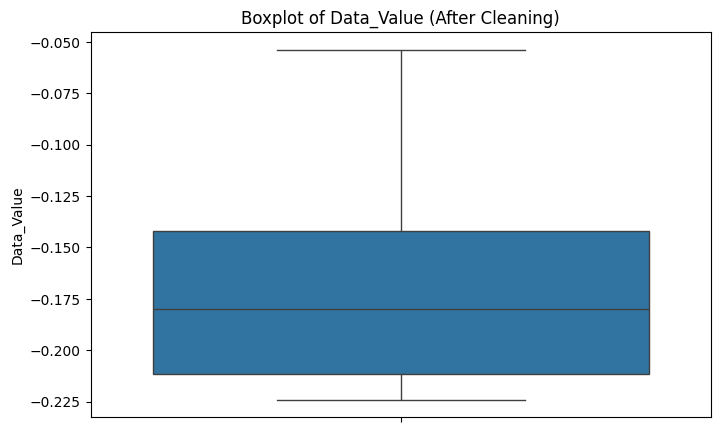

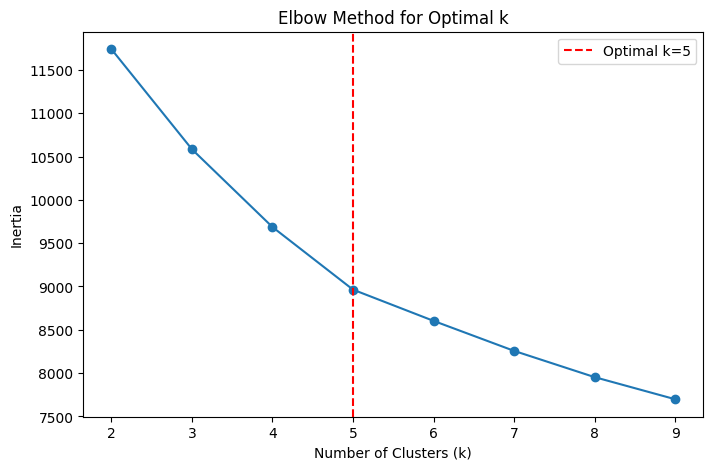

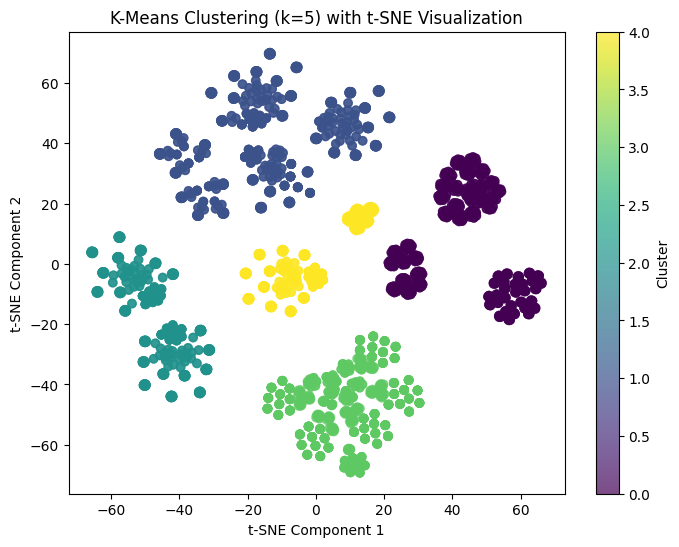

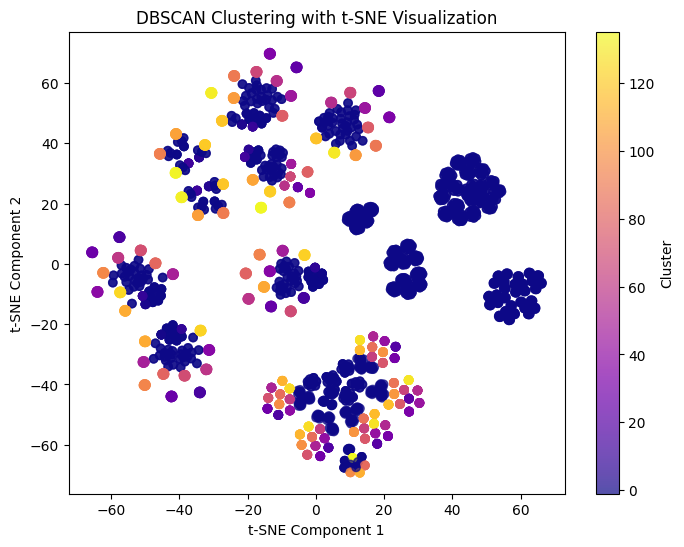

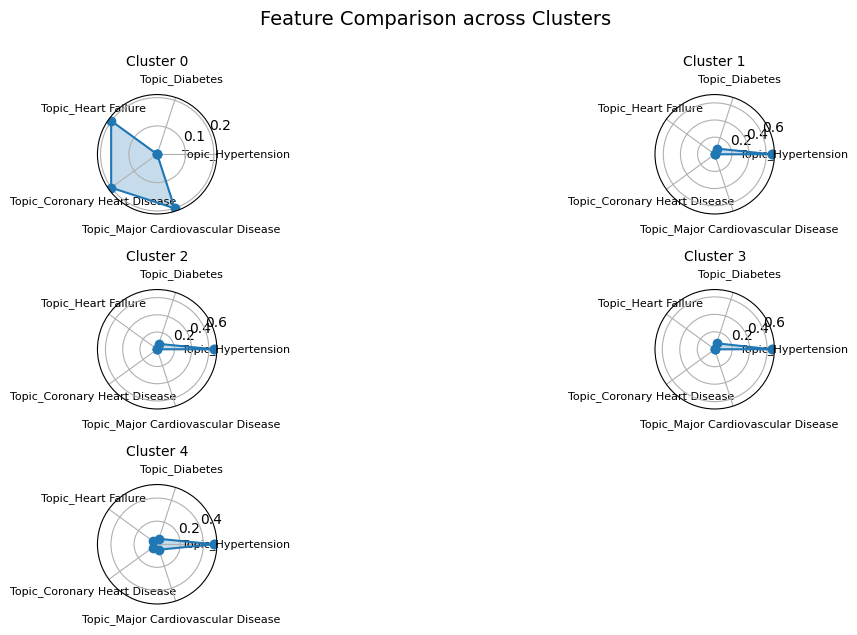

Cluster 0 Health Advice:
- Topic_Heart Failure: Have regular heart checkups, control your weight, and avoid a high-fat diet.
- Topic_Coronary Heart Disease: Stop smoking, reduce saturated fat intake, and increase aerobic exercise.
- Topic_Major Cardiovascular Disease: Have regular medical check-ups and follow your doctor's recommendations for medication.


Cluster 1 Health Advice:
- Topic_Hypertension: Reduce salt intake, stay active, and monitor blood pressure daily.
- Topic_Diabetes: Control your blood sugar levels, avoid high-sugar foods and maintain a healthy diet.


Cluster 2 Health Advice:
- Topic_Hypertension: Reduce salt intake, stay active, and monitor blood pressure daily.


Cluster 3 Health Advice:
- Topic_Diabetes: Control your blood sugar levels, avoid high-sugar foods and maintain a healthy diet.


Cluster 4 Health Advice:
- Topic_Heart Failure: Have regular heart checkups, control your weight, and avoid a high-fat diet.
- Topic_Coronary Heart Disease: Stop smoking, reduc

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kneed import KneeLocator

#retrieve data
file_path = "National_Health_and_Nutrition_Examination_Survey__NHANES__-_National_Cardiovascular_Disease_Surveillance_System.csv"
df = pd.read_csv(file_path)

#Selection of key features
selected_columns = ['YearStart', 'Class', 'Topic', 'Break_Out_Category', 'Break_Out', 'Data_Value']
df_selected = df[selected_columns].copy()
df_selected = df_selected.dropna()

#Perform One-Hot coding
df_encoded = pd.get_dummies(df_selected, columns=['Class', 'Topic', 'Break_Out_Category', 'Break_Out', 'YearStart'])

#Standardised value columns
scaler = StandardScaler()
df_encoded['Data_Value'] = scaler.fit_transform(df_encoded[['Data_Value']])

#Plotting the box before cleaning
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_encoded['Data_Value'])
plt.title('Boxplot of Data_Value (Before Cleaning)')
plt.ylabel('Data_Value')
plt.show()

#Filtering outliers
Q1 = df_encoded['Data_Value'].quantile(0.25)
Q3 = df_encoded['Data_Value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_cleaned = df_encoded[(df_encoded['Data_Value'] >= lower_bound) & (df_encoded['Data_Value'] <= upper_bound)].copy()

#Plotting the cleaned box
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_cleaned['Data_Value'])
plt.title('Boxplot of Data_Value (After Cleaning)')
plt.ylabel('Data_Value')
plt.show()

#Selection of optimal number of clusters
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cleaned)
    inertia.append(kmeans.inertia_)

knee_locator = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
best_k = knee_locator.elbow

#Charting the Law of the Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.axvline(best_k, color='r', linestyle='--', label=f'Optimal k={best_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()

#Perform K-Means clustering
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_cleaned.loc[:, 'KMeans_Cluster'] = kmeans.fit_predict(df_cleaned)

#Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_cleaned.loc[:, 'DBSCAN_Cluster'] = dbscan.fit_predict(df_cleaned)

#t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(df_cleaned.iloc[:, :-2])
df_cleaned.loc[:, 'TSNE1'] = tsne_results[:, 0]
df_cleaned.loc[:, 'TSNE2'] = tsne_results[:, 1]

#Visual K-Means Clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_cleaned['TSNE1'], df_cleaned['TSNE2'], c=df_cleaned['KMeans_Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title(f'K-Means Clustering (k={best_k}) with t-SNE Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

#Visualising DBSCAN clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_cleaned['TSNE1'], df_cleaned['TSNE2'], c=df_cleaned['DBSCAN_Cluster'], cmap='plasma', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('DBSCAN Clustering with t-SNE Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

#Calculate the average eigenvalue for each cluster
cluster_means = df_cleaned.groupby("KMeans_Cluster").mean()

#Generate optimisation radar charts
features = ['Topic_Hypertension', 'Topic_Diabetes', 'Topic_Heart Failure', 'Topic_Coronary Heart Disease', 'Topic_Major Cardiovascular Disease']
num_clusters = best_k

fig, axes = plt.subplots(nrows=int(np.ceil(num_clusters / 2)), ncols=2, figsize=(12, 6), subplot_kw=dict(polar=True))
axes = axes.flatten()

for i, cluster_id in enumerate(cluster_means.index):
    values = cluster_means.loc[cluster_id, features].values
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]
    
    ax = axes[i]
    ax.fill(angles, values, alpha=0.25)
    ax.plot(angles, values, marker='o')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=8)
    ax.set_title(f'Cluster {cluster_id}', fontsize=10)

#Hide redundant subgraphs
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Feature Comparison across Clusters', fontsize=14, y=1.05)
plt.show()


#Generating health advice
def generate_health_advice(cluster_means, features):
    health_advice = {
        "Hypertension": "Reduce salt intake, stay active, and monitor blood pressure daily.",
        "Diabetes": "Control your blood sugar levels, avoid high-sugar foods and maintain a healthy diet.",
        "Heart Failure": "Have regular heart checkups, control your weight, and avoid a high-fat diet.",
        "Coronary Heart Disease": "Stop smoking, reduce saturated fat intake, and increase aerobic exercise.",
        "Major Cardiovascular Disease": "Have regular medical check-ups and follow your doctor's recommendations for medication."
    }
    
    thresholds = cluster_means[features].median()  #Dynamic threshold calculation
    
    for cluster_id in cluster_means.index:
        print(f"Cluster {cluster_id} Health Advice:")
        advice_given = False
        for feature in features:
            if cluster_means.loc[cluster_id, feature] > thresholds[feature]:
                print(f"- {feature}: {health_advice[feature.split('_')[1]]}")
                advice_given = True
        
        if not advice_given:
            print("Maintain a balanced diet, moderate exercise and regular medical check-ups.")
        print("\n")

features = ['Topic_Hypertension', 'Topic_Diabetes', 'Topic_Heart Failure', 'Topic_Coronary Heart Disease', 'Topic_Major Cardiovascular Disease']
generate_health_advice(cluster_means, features)